# Notebook for analyzing correlation between nyctlc taxi data and twitter for sandy.

The nyctlc taxi data is standardized to data from the year 2012.

In [1]:
%matplotlib inline
import sys
import os
sys.path.append(os.path.abspath('../'))

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import pandas as pd
import scipy
import scipy.signal
import seaborn as sns
sns.set()

from twitterinfrastructure.tools import connect_db, output, query
import twitterinfrastructure.analysis as asys
import twitterinfrastructure.analyze_nyctlc as taxi
import twitterinfrastructure.twitter_sandy as ts

import importlib
importlib.reload(asys)
importlib.reload(taxi)
importlib.reload(ts)

#os.chdir('../')
print(os.getcwd())

matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **{'family': "serif"})
params = {'text.latex.preamble': [r'\usepackage{siunitx}', 
                                  r'\usepackage{amsmath}']}
plt.rcParams.update(params)
sns.set_context('paper')
sns.set_style('darkgrid')

C:\dev\research\socialsensing\notebooks


# Analyze correlation between total dropoff z-scores and sandy tweets.

Data is grouped by zone. Loading takes ~2 minutes.

In [25]:
trip_count_filter = 5
tweet_count_filter = 5
db_path = 'data/processed/nyctlc-2012.db'
startdate = pd.Timestamp('2012-10-28 00:00:00', 
                         tz='America/New_York')  # inclusive
enddate = pd.Timestamp('2012-11-03 00:00:00', 
                       tz='America/New_York')  # exclusive

# load taxi dropoff and pickup data (filtered by dates, grouped by zone)
df_drop_group = asys.load_nyctlc_zone(startdate, enddate, 'dropoff', 
                                      trip_count_filter, db_path, verbose=2)
df_pick_group = asys.load_nyctlc_zone(startdate, enddate, 'pickup', 
                                      trip_count_filter, db_path, verbose=2)

# load normalized sandy-related tweets (filtered by dates, grouped by zone)
df_tweets = ts.query_groupby_norm('tweets_sandy', 'tweets_analysis', 
                                  'location_id', None, tweet_count_filter, 
                                  startdate=startdate, enddate=enddate, 
                                  verbose=2)
df_tweets = df_tweets.rename(columns={'tweets': 'sandy-tweets', 
                                      'tweets-norm': 'sandy-tweets-norm'})

# combine into base nan dataframe
cols = list(df_drop_group.columns.values) + \
       list(df_pick_group.columns.values) + \
       list(df_tweets.columns.values)
df = pd.DataFrame(np.nan, index=range(1, 264), columns=pd.unique(cols))
df.index.name = 'location_id'
df.update(df_drop_group)
df.update(df_pick_group)
df.update(df_tweets[['sandy-tweets', 'sandy-tweets-norm']])

# add log transformed columns and replace infinite values with nan 
for col in df.columns.values:
    df['log-' + col] = np.log(df[col])
df = df.replace([np.inf, -np.inf], np.nan)

# export total dataframe to csv
print('Dataframe rows: ' + str(df.shape[0]))
# path = 'data/processed/taxi-summary-zone.csv'
# df.to_csv(path, index_label='zone')

2018-10-03 14:18:32 : Started query.

2018-10-03 14:18:33 : [min, max] taxi datetimeNY (hourly): [2012-10-28 00:00:00-04:00, 2012-11-02 23:00:00-04:00].

2018-10-03 14:18:33 : [min, max] taxi pace and trips mean z-score (hourly): [-37.8165701074617, 160.71751319680212], [-0.8207678323173992, 23.07142857142857].

2018-10-03 14:18:33 : [min, max] taxi pace and trips mean z-score: [-5.417848880988211, 8.961342953858054], [-0.1922866202961958, 6.217105263157895].

2018-10-03 14:18:33 : Started query.

2018-10-03 14:18:34 : [min, max] taxi datetimeNY (hourly): [2012-10-28 00:00:00-04:00, 2012-11-02 23:00:00-04:00].

2018-10-03 14:18:34 : [min, max] taxi pace and trips mean z-score (hourly): [-118.74209588060178, 155.43379084178224], [-0.921073637996408, inf].

2018-10-03 14:18:34 : [min, max] taxi pace and trips mean z-score: [-6.086069819074376, 5.6622370890467995], [-0.2336790247714764, inf].

2018-10-03 14:18:34 : Started query.

2018-10-03 14:18:34 : Started query.

2018-10-03 14:18:37 

/Users/httran/anaconda3/envs/twitterinfrastructure/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log


Num data points: 198

Pearson correlation coefficient: -0.5026391651547191
Pearson correlation p-value: 4.501045053369945e-14

Spearman correlation coefficient: -0.5556735205305207
Spearman correlation p-value: 1.9430436177264896e-17

Kendall tau correlation coefficient: -0.3779002693204527
Kendall tau correlation p-value: 2.654306874332331e-15



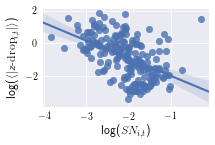

In [5]:
# plot total correlations
plotx = 'log-sandy-tweets-norm'
ploty = 'log-abs-ztrips-drop'

# define dataframe to plot
df_plot = pd.DataFrame()
df_plot['x'] = df[plotx]
df_plot['y'] = df[ploty]
df_plot = df_plot.dropna()
print('Num data points: ' + str(df_plot.shape[0]))
print('')

# correlation
r, p = scipy.stats.pearsonr(df_plot['x'], df_plot['y'])
print('Pearson correlation coefficient: ' + str(r))
print('Pearson correlation p-value: ' + str(p))
print('')
rho, p = scipy.stats.spearmanr(df_plot['x'], df_plot['y'])
print('Spearman correlation coefficient: ' + str(rho))
print('Spearman correlation p-value: ' + str(p))
print('')
tau, p = scipy.stats.kendalltau(df_plot['x'], df_plot['y'])
print('Kendall tau correlation coefficient: ' + str(tau))
print('Kendall tau correlation p-value: ' + str(p))
print('')

# scatterplot
# fig, ax = plt.subplots(figsize=(6, 4), tight_layout=False)
fig, ax = plt.subplots(figsize=(3, 2), tight_layout=False)
ax = sns.regplot('x', 'y',
                 data=df_plot, fit_reg=True,
                 scatter_kws={'marker': 'D', 's': 50},
                 ax=ax)

# axes
fig.tight_layout()
ax.tick_params(axis='both', colors='k')
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel(plotx)
ax.set_ylabel(ploty)

# save
# ax.set_xlabel(r'log($M_{\text{Sandy}}/N$)', color='k', size=12)
# ax.set_ylabel(r'log($\langle |z_d| \rangle$)', color='k', size=12)
ax.set_xlabel(r'log($SN_{i,t}$)', color='k', size=12)
ax.set_ylabel(r'log($\langle | z\textnormal{-drop}_{i,t} | \rangle$)', 
              color='k', size=12)
plt.savefig('notebooks/images/report/taxi-totalcorrelation.png', dpi=150, 
            bbox_inches='tight')

# pick out points
# df.loc[df[plotx].idxmax()]

# Analyze correlation between daily dropoff z-scores and sandy tweets.

In [23]:
trip_count_filter = 5
tweet_count_filter = 5
db_path = 'data/processed/nyctlc-2012.db'
startdate = pd.Timestamp('2012-10-28 00:00:00', 
                         tz='America/New_York')  # inclusive
enddate = pd.Timestamp('2012-11-03 00:00:00', 
                       tz='America/New_York')  # exclusive

# load taxi dropoff and pickup data (filtered by dates, grouped by zone-date)
df_drop = asys.load_nyctlc_zone_date(startdate, enddate, 'dropoff', 
                                     trip_count_filter, db_path, verbose=2)
df_pick = asys.load_nyctlc_zone_date(startdate, enddate, 'pickup', 
                                     trip_count_filter, db_path, verbose=2)

# load normalized sandy-related tweets (filtered by dates, grouped by zone-date)
df_tweets = ts.query_groupby_norm('tweets_sandy', 'tweets_analysis', 
                                  'location_id', 'date', tweet_count_filter, 
                                  startdate=startdate, enddate=enddate, 
                                  verbose=2)
df_tweets = df_tweets.rename(columns={'tweets': 'sandy-tweets', 
                                      'tweets-norm': 'sandy-tweets-norm'})

# combine into one dataframe
df_tweets.index.names = ['location_id', 'datetimeNY']   # temp (merge)
df = pd.merge(df_drop, df_pick, how='outer', left_index=True, 
              right_index=True)
df = pd.merge(df, df_tweets, how='left', left_index=True, 
              right_index=True)

# add log transformed columns and replace infinite values with nan
for col in df.columns.values:
    df['log-' + col] = np.log(df[col])
df = df.replace([np.inf, -np.inf], np.nan)

# export total dataframe to csv
print('Dataframe rows: ' + str(df.shape[0]))
# path = 'data/processed/taxi-summary-zone.csv'
# df.to_csv(path, index_label='zone')

2018-10-03 14:14:28 : Started query.

2018-10-03 14:14:29 : [min, max] taxi datetimeNY (hourly): [2012-10-28 00:00:00-04:00, 2012-11-02 23:00:00-04:00].

2018-10-03 14:14:29 : [min, max] taxi pace and trips mean z-score (hourly): [-37.8165701074617, 160.71751319680212], [-0.8207678323173992, 23.07142857142857].

2018-10-03 14:14:29 : [min, max] taxi pace and trips mean z-score: [-19.573573413192157, 27.72075551782034], [-0.47423134674051326, 23.07142857142857].

2018-10-03 14:14:29 : Started query.

2018-10-03 14:14:30 : [min, max] taxi datetimeNY (hourly): [2012-10-28 00:00:00-04:00, 2012-11-02 23:00:00-04:00].

2018-10-03 14:14:30 : [min, max] taxi pace and trips mean z-score (hourly): [-118.74209588060178, 155.43379084178224], [-0.921073637996408, inf].

2018-10-03 14:14:30 : [min, max] taxi pace and trips mean z-score: [-16.014054890528957, 18.420596538401597], [-0.3494354289337188, inf].

2018-10-03 14:14:30 : Started query.

2018-10-03 14:14:30 : Started query.

2018-10-03 14:14:

/Users/httran/anaconda3/envs/twitterinfrastructure/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log


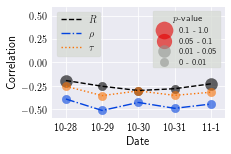

In [25]:
# plot zone correlation by day
ploty1 = 'sandy-tweets-norm'
ploty2 = 'ztrips-drop'
df_ts = df[[ploty1, ploty2]].dropna() 
df_ts = df_ts.reset_index()
df_ts = df_ts.set_index(['datetimeNY', 'location_id'])
df_ts = df_ts.sort_index(level=0)

# calculate correlations
datetimes = list(np.unique(df_ts.index.get_level_values(0)))
corr = pd.DataFrame(columns=['pearson', 'p_pearson', 'spearman', 'p_spearman',
                             'kendall', 'p_kendall', 'count'],
                    index=datetimes, dtype=float)
for datetime in datetimes:
    df_dt = df_ts.xs(datetime, level=0)
    r, p_pearson = scipy.stats.pearsonr(df_dt[ploty1], df_dt[ploty2])
    rho, p_spearman = scipy.stats.spearmanr(df_dt[ploty1], df_dt[ploty2])
    tau, p_kendall = scipy.stats.kendalltau(df_dt[ploty1], df_dt[ploty2])
    corr.loc[datetime] = [r, p_pearson, rho, p_spearman, tau, p_kendall, 
                          df_dt.shape[0]]
corr['count'] = corr['count'].astype(int)

# figure
# fig, ax = plt.subplots(figsize=(8, 4), tight_layout=False)
fig, ax = plt.subplots(figsize=(3, 2), tight_layout=False)
colors = ['black', 'blue', 'orange']
colors_str = ['xkcd:' + color for color in colors]
days = [str(date.month) + '-' + str(date.day) for date in 
        pd.to_datetime(datetimes)]

# line plots for correlations
ax.plot(days, corr['pearson'], color=colors_str[0], linestyle='--')
ax.plot(days, corr['spearman'], color=colors_str[1], linestyle='-.')
ax.plot(days, corr['kendall'], color=colors_str[2], linestyle=':')
leg_lines = ax.legend([r'$R$', r'$\rho$', r'$\tau$'], loc='upper left', 
                      fontsize=10, frameon=True, fancybox=True, 
                      facecolor='xkcd:light grey')

# scatter plots for p-values
marker_alpha = 0.6
bins = [0, 0.01, 0.05, 0.1, 1.0]
sizes = [75 * (i + 1) for i in range(len(bins) - 1)]
grouped = corr.groupby(np.digitize(corr['p_pearson'], bins))
for bin_num, group in grouped:
    if bins[bin_num - 1] >= 0.05:
        color = 'xkcd:red'
    else:
        color = colors_str[0]
    days = [str(date.month) + '-' + str(date.day) for date in 
            pd.to_datetime(group.index.values)]
    plt.scatter(days, group['pearson'], s=sizes[bin_num - 1], 
                alpha=marker_alpha, color=color)
grouped = corr.groupby(np.digitize(corr['p_spearman'], bins))
for bin_num, group in grouped:
    if bins[bin_num - 1] >= 0.05:
        color = 'xkcd:red'
    else:
        color = colors_str[1]
    days = [str(date.month) + '-' + str(date.day) for date in
            pd.to_datetime(group.index.values)]
    plt.scatter(days, group['spearman'], s=sizes[bin_num - 1], 
                alpha=marker_alpha, color=color)
grouped = corr.groupby(np.digitize(corr['p_kendall'], bins))
for bin_num, group in grouped:
    if bins[bin_num - 1] >= 0.05:
        color = 'xkcd:red'
    else:
        color = colors_str[2]
    days = [str(date.month) + '-' + str(date.day) for date in
            pd.to_datetime(group.index.values)]
    plt.scatter(days, group['kendall'], s=sizes[bin_num - 1], 
                alpha=marker_alpha, color=color)
if max(bins) < max(max(corr['p_pearson']), 
                   max(corr['p_spearman']), 
                   max(corr['p_kendall'])):
    output('p-value larger than max bin size', 'Warning')
    print('max p-value: ' + str(max(max(corr['p_pearson']),
                                    max(corr['p_spearman']),
                                    max(corr['p_kendall']))))

# axes
fig.tight_layout()
ax.tick_params(axis='both', colors='k', labelsize=10)
ax.set_xlabel('Date', color='k', size=16)
ax.set_ylabel('Correlation: ' + ploty1 + ', ' + ploty2, color='k', size=12)
ax.set_ylim(-0.6, 0.6)

# marker legend
markers = []
labels = []
for i, size in reversed(list(enumerate(sizes))):
    if bins[i] >= 0.05:
        color = 'xkcd:red'
    else:
        color = 'xkcd:grey'
    markers.append(plt.scatter([], [], s=size, alpha=marker_alpha, color=color))
    labels.append(str(bins[i]) + ' - ' + str(bins[i + 1]))
leg_markers = ax.legend(handles=markers, labels=labels, loc='upper right',
                        scatterpoints=1, frameon=True, fancybox=True,
                        facecolor='xkcd:light grey', title=r'$p$-value')
plt.gca().add_artist(leg_lines)  # add lines legend back to plot

# save
fig.set_size_inches(3, 2)
ax.set_xlabel(r'Date', color='k', size=12)
ax.set_ylabel(r'Correlation', color='k', size=12)
plt.savefig('notebooks/images/report/taxi-dailycorrelation.png', dpi=150, 
            bbox_inches='tight')

Cross-correlation for zone 236: [-0.94280632]

Cross-correlation for zone 186: [-0.45276873]



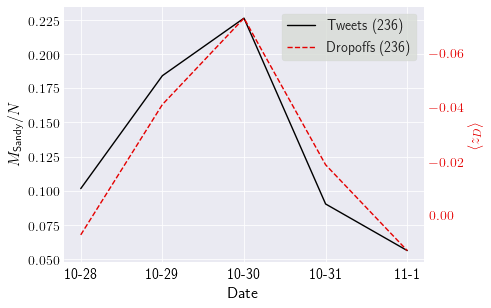

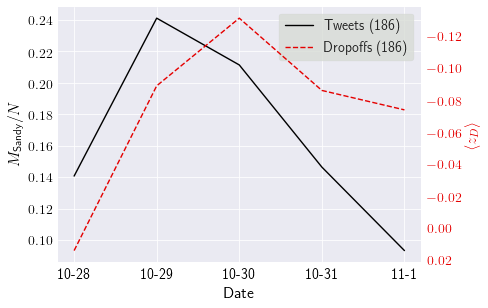

In [26]:
# plot daily time series
ploty1 = 'sandy-tweets-norm'
ploty2 = 'ztrips-drop'
df_ts = df[[ploty1, ploty2]].dropna()
zones = [236, 186]

colors1 = ['black', 'red', 'blue']
# colors_str1 = ['xkcd:' + color for color in colors1]
linestyles = ['-', '--', ':']
days = [str(date.month) + '-' + str(date.day) for date in 
        pd.to_datetime(df_ts.index.get_level_values(1))]
days = np.unique(days)
lines = []
for zone, linestyle in zip(zones, linestyles):
    df_plt = df_ts.xs(zone, level=0)

    # normalized cross-correlation
    a = df_plt[ploty1]
    b = df_plt[ploty2]
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
    rho = np.correlate(a, b)
    print('Cross-correlation for zone {zone}: {rho}'.format(zone=zone, 
                                                            rho=rho))
    print('')
    
    # figure
    fig, ax1 = plt.subplots(figsize=(6, 4), tight_layout=False)
    ax2 = ax1.twinx()
    ax2.grid(None)

    # shaded line plots for current zone
    line = ax1.plot(days, df_plt[ploty1], color='xkcd:black', 
                    linestyle=linestyles[0])
    lines.append(line[0])
    # ax1.fill_between(days, df_plt[ploty1], color='xkcd:black', 
    #                  linestyle=linestyles[0], alpha=0.4)
    line = ax2.plot(days, df_plt[ploty2], color='xkcd:red', 
                    linestyle=linestyles[1])
    lines.append(line[0])
    # ax2.fill_between(days, df_plt[ploty2], color='xkcd:red', 
    #                  linestyle=linestyles[1], alpha=0.4)

    # axes
    fig.tight_layout()
    ax1.tick_params(axis='both', colors='k', labelsize=14)
    ax1.set_xlabel('Date', color='k', size=16)
    ax1.set_ylabel(ploty1, color='k', size=16)
    ax2.tick_params(axis='y', labelcolor='xkcd:red', labelsize=14)
    ax2.set_ylabel(ploty2, color=colors1[0], size=16)
    ax2.invert_yaxis()
    leg = ax1.legend(list(map(str, zones)), 
                     loc='best', fontsize=14, 
                     frameon=True, fancybox=True, facecolor='xkcd:light grey')
    
    # save
    ax1.set_ylabel(r'$M_{\text{Sandy}}/N$', color='k', size=16)
    ax2.set_ylabel(r'$\langle z_D \rangle$', color='xkcd:red', size=16)
    # lines = lines[[0, 2, 1, 3]]
    labels = ['Tweets ({z1})'.format(z1=zone), 
              'Dropoffs ({z1})'.format(z1=zone)]
    leg = ax1.legend(handles=lines, labels=labels, loc='best', fontsize=14, 
                     frameon=True, fancybox=True, facecolor='xkcd:light grey')
    plt.savefig('notebooks/images/dailycrosscorrelation-'
                '{zone}-timeseries.png'.format(zone=zone), 
                dpi=150, 
                bbox_inches='tight')

Number of zones with at least 5 tweets for required days: 64


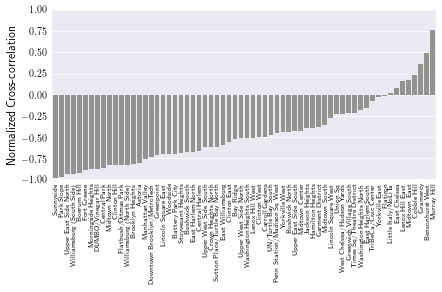

In [27]:
# plot daily cross-correlations for all zones
# only include those with at least tweet_count_filter tweets for required days
ploty1 = 'sandy-tweets-norm'
ploty2 = 'ztrips-drop'
df_ts = df[[ploty1, ploty2]].dropna()

# load zone to zone name mapping
db_path = 'data/processed/nyctlc-2012.db'
sql = """
        SELECT location_id AS zone, zone_name AS name
        FROM taxi_zones_2012
      ;"""
df_zonenames = query(db_path, sql)
df_zonenames = df_zonenames.set_index('zone')

# calculate cross-correlations
zones = df_ts.index.get_level_values(0).unique()
required_days = ['10-28', '10-29', '10-30', '10-31', '11-1']
df_ccr = pd.DataFrame({'norm-ccr': [], 'name': []})
for zone in zones:
    df_zone = df_ts.xs(zone, level=0)
    days = [str(date.month) + '-' + str(date.day) for date in
            pd.to_datetime(df_zone.index.values)]

    if days == required_days:
        a = df_zone[ploty1]
        b = df_zone[ploty2]
        a = (a - np.mean(a)) / (np.std(a) * len(a))
        b = (b - np.mean(b)) / (np.std(b))
        rho = np.correlate(a, b)
        name = df_zonenames.loc[zone, 'name']
        df_ccr = df_ccr.append(pd.Series([rho[0], name], name=zone, 
                                         index=['norm-ccr', 'name']))

print('Number of zones with at least {tweet_filter} tweets '
      'for required days: {nzones}'.format(tweet_filter=tweet_count_filter, 
                                           nzones=df_ccr.shape[0]))

df_ccr = df_ccr.sort_values(by=['norm-ccr'])

# figure, barplot, and axes
# fig, ax = plt.subplots(figsize=(6, 8), tight_layout=False)
# sns.barplot(x='norm-ccr', y='name', data=df_ccr, color='xkcd:grey', ax=ax)
# fig.tight_layout()
# ax.tick_params(axis='x', colors='k', labelsize=14)
# ax.tick_params(axis='y', colors='k', labelsize=9)
# ax.set_xlabel('Normalized Cross-correlation (Daily)', color='k', size=16)
# ax.set_ylabel('')
# ax.set(xlim=(-1, 1))
fig, ax = plt.subplots(figsize=(6.5, 3), tight_layout=False)
sns.barplot(y='norm-ccr', x='name', data=df_ccr, color='xkcd:grey', ax=ax)
fig.tight_layout()
ax.tick_params(axis='x', colors='k', labelsize=7)
plt.xticks(rotation=90)
ax.tick_params(axis='y', colors='k', labelsize=10)
ax.set_ylabel('Normalized Cross-correlation', color='k', size=12)
ax.set_xlabel('')
ax.set(ylim=(-1, 1))

# save
fig.set_size_inches(6.5, 3)
plt.savefig('notebooks/images/report/taxi-dailyccr-bar.png', 
            dpi=150, 
            bbox_inches='tight')

Dataframe rows: 585
Pearson correlation coefficient: -0.1962439812982917
Pearson correlation p-value: 1.7274863943878843e-06

Spearman correlation coefficient: -0.20876020779976232
Spearman correlation p-value: 3.4934131524834443e-07

Kendall tau correlation coefficient: -0.13409625094322392
Kendall tau correlation p-value: 1.2435440418099287e-06



Text(0,0.5,'log-abs-ztrips-drop')

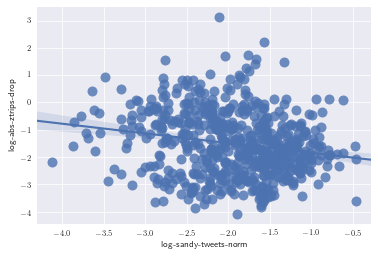

In [28]:
# scatterplot of daily correlations (not useful)
plotx = 'log-sandy-tweets-norm'
ploty = 'log-abs-ztrips-drop'

# define dataframe to plot
df_plot = pd.DataFrame()
df_plot['x'] = df[plotx]
df_plot['y'] = df[ploty]
df_plot = df_plot.dropna()

print('Dataframe rows: ' + str(df_plot.shape[0]))

# correlation
r, p = scipy.stats.pearsonr(df_plot['x'], df_plot['y'])
print('Pearson correlation coefficient: ' + str(r))
print('Pearson correlation p-value: ' + str(p))
print('')
rho, p = scipy.stats.spearmanr(df_plot['x'], df_plot['y'])
print('Spearman correlation coefficient: ' + str(rho))
print('Spearman correlation p-value: ' + str(p))
print('')
tau, p = scipy.stats.kendalltau(df_plot['x'], df_plot['y'])
print('Kendall tau correlation coefficient: ' + str(tau))
print('Kendall tau correlation p-value: ' + str(p))
print('')

# scatterplot
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=False)
ax = sns.regplot('x', 'y', data=df_plot, 
                 fit_reg=True, scatter_kws={'marker': 'D', 's': 100}, ax=ax)
ax.set_xlabel(plotx)
ax.set_ylabel(ploty)

## Analyze correlation between hourly zone traffic z-scores and traffic-related tweets.

In [14]:
trip_count_filter = 5   # by hour
tweet_count_filter = 5  # by day
db_path = 'data/processed/nyctlc-2012.db'
startdate = pd.Timestamp('2012-10-28 00:00:00', 
                         tz='America/New_York')  # inclusive
enddate = pd.Timestamp('2012-11-03 00:00:00', 
                       tz='America/New_York')  # exclusive

# load taxi dropoff and pickup data (filtered by dates, grouped by zone-hour)
df_drop = asys.load_nyctlc_zone_hour(startdate, enddate, 'dropoff', 
                                     trip_count_filter, db_path, verbose=2)
df_pick = asys.load_nyctlc_zone_hour(startdate, enddate, 'pickup', 
                                     trip_count_filter, db_path, verbose=2)

# load normalized sandy-related tweets (filtered by dates, grouped by zone-hour)
df_tweets = ts.query_groupby_hour_norm('tweets_sandy', 'tweets_analysis', 
                                       'location_id', tweet_count_filter, 
                                       startdate=startdate, enddate=enddate, 
                                       verbose=2)
df_tweets = df_tweets.rename(columns={'tweets': 'sandy-tweets', 
                                      'tweets-norm': 'sandy-tweets-norm'})

# combine into one dataframe
df_tweets.index.names = ['location_id', 'datetimeNY']   # temp (merge)
df = pd.merge(df_drop, df_pick, how='outer', left_index=True, right_index=True)
df = pd.merge(df, df_tweets, how='left', left_index=True, 
              right_index=True)

# add log transformed columns and replace infinite values with nan
# for col in df.columns.values:
#     df['log-' + col] = np.log(df[col])
df = df.replace([np.inf, -np.inf], np.nan)

# export hourly dataframe to csv
print('Dataframe rows: ' + str(df.shape[0]))
# path = 'data/processed/summary_zone_hour.csv'
# df.to_csv(path, index_label=['zone', 'datetime'])

2018-10-03 13:51:21 : Started query.

2018-10-03 13:51:22 : [min, max] taxi datetimeNY (hourly): [2012-10-28 00:00:00-04:00, 2012-11-02 23:00:00-04:00].

2018-10-03 13:51:22 : [min, max] taxi pace and trips mean z-score (hourly): [-37.8165701074617, 160.71751319680212], [-0.8207678323173992, 23.07142857142857].

2018-10-03 13:51:22 : Started query.

2018-10-03 13:51:24 : [min, max] taxi datetimeNY (hourly): [2012-10-28 00:00:00-04:00, 2012-11-02 23:00:00-04:00].

2018-10-03 13:51:24 : [min, max] taxi pace and trips mean z-score (hourly): [-118.74209588060178, 155.43379084178224], [-0.921073637996408, inf].

2018-10-03 13:51:24 : Started query.

2018-10-03 13:51:24 : Started query.

2018-10-03 13:51:24 : [min, max] tweets datetime from tweets_sandy: [2012-10-28 00:00:00-04:00, 2012-11-02 00:00:00-04:00].

2018-10-03 13:51:25 : [min, max] number of tweets from tweets_sandy: [5, 83].

2018-10-03 13:51:25 : Finished query.

2018-10-03 13:51:25 : Started query.

2018-10-03 13:51:32 : [min, 

zones with the most data points: 
location_id
48     42
230    38
263    26
Name: sandy-tweets-norm, dtype: int64

Cross-correlation for zone 48: [-0.41110035]

Cross-correlation for zone 230: [-0.34740784]



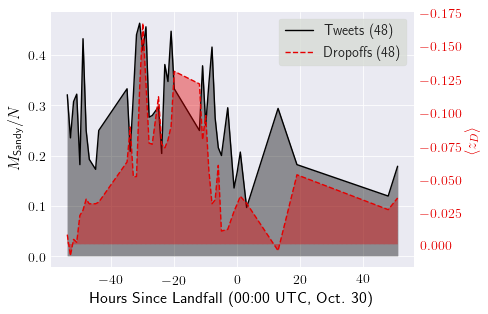

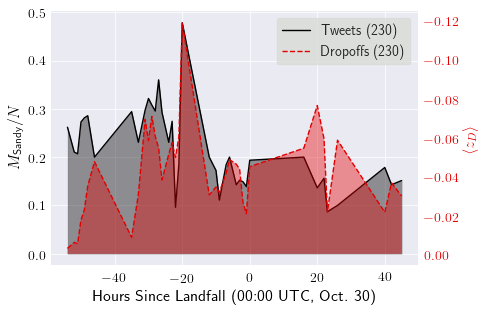

In [15]:
# plot hourly time series
ploty1 = 'sandy-tweets-norm'
ploty2 = 'ztrips-drop'
df_ts = df[[ploty1, ploty2]].dropna()
counts = df_ts.count(level='location_id')[ploty1]
counts = counts.sort_values(ascending=False)
top_counts = counts[0:3]
# zones = top_counts.index.values
zones = [48, 230]
print('zones with the most data points: ')
print(top_counts)
print('')

# reindex on timedelta
df_ts['timedelta'] = df_ts.index.get_level_values('datetimeNY') - \
                     pd.Timestamp('2012-10-30 20:00:00', tz='America/New_York')
df_ts['timedelta'] = [td.total_seconds() / 3600 for td in df_ts['timedelta']]
df_ts = df_ts.reset_index()
df_ts = df_ts.set_index(['location_id', 'timedelta'])
df_ts = df_ts.sort_index(level=0)

# colors1 = ['black', 'red', 'blue']
# colors_str1 = ['xkcd:' + color for color in colors1]
linestyles = ['-', '--', ':']
lines = []
for zone, linestyle in zip(zones, linestyles):
    df_plt = df_ts.xs(zone, level=0)

    # normalized cross-correlation
    a = df_plt[ploty1]
    b = df_plt[ploty2]
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
    rho = np.correlate(a, b)
    print('Cross-correlation for zone {zone}: {rho}'.format(zone=zone, 
                                                            rho=rho))
    print('')

    # figure
    fig, ax1 = plt.subplots(figsize=(6, 4), tight_layout=False)
    ax2 = ax1.twinx()
    ax2.grid(None)

    # shaded line plots for current zone
    line = ax1.plot(df_plt.index.get_level_values('timedelta'), df_plt[ploty1], 
                    color='xkcd:black', linestyle=linestyles[0])
    ax1.fill_between(df_plt.index.get_level_values('timedelta'), df_plt[ploty1],
                     color='xkcd:black', linestyle=linestyles[0], alpha=0.4)
    lines.append(line[0])
    line = ax2.plot(df_plt.index.get_level_values('timedelta'), df_plt[ploty2], 
                    color='xkcd:red', linestyle=linestyles[1])
    ax2.fill_between(df_plt.index.get_level_values('timedelta'), df_plt[ploty2],
                     color='xkcd:red', linestyle=linestyles[1], alpha=0.4)
    lines.append(line[0])

    # axes
    fig.tight_layout()
    ax1.tick_params(axis='both', colors='k', labelsize=14)
    ax1.set_xlabel('Hours Since Landfall (00:00 UTC, Oct. 30)', color='k',
                   size=16)
    ax1.set_ylabel(ploty1, color='k', size=16)
    ax2.tick_params(axis='y', labelcolor='xkcd:red', labelsize=14)
    ax2.set_ylabel(ploty2, color='xkcd:red', size=16)
    ax2.invert_yaxis()
    leg = ax1.legend(list(map(str, zones)), 
                     loc='best', fontsize=14, 
                     frameon=True, fancybox=True, facecolor='xkcd:light grey')

    # save
    ax1.set_ylabel(r'$M_{\text{Sandy}}/N$', color='k', size=16)
    ax2.set_ylabel(r'$\langle z_D \rangle$', color='xkcd:red', size=16)
    # lines = lines[[0, 2, 1, 3]]
    labels = ['Tweets ({z1})'.format(z1=zone), 
              'Dropoffs ({z1})'.format(z1=zone)]
    leg = ax1.legend(handles=lines, labels=labels, loc='best', fontsize=14, 
                     frameon=True, fancybox=True, facecolor='xkcd:light grey')
    # plt.savefig('notebooks/images/hourlycrosscorrelation-'
    #             '{zone}-timeseries.png'.format(zone=zone), 
    #             dpi=150, 
    #             bbox_inches='tight')

Number of zones with at least 5 tweets for 10.0 percent of possible hours in time period: 14


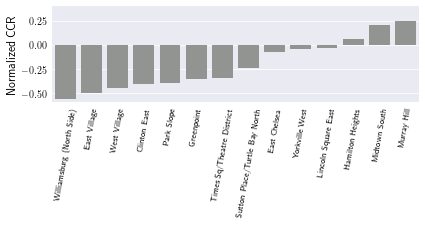

In [8]:
# plot hourly cross-correlations for all zones
# only include those with at least tweet_count_filter tweets for required 
# num hours
ploty1 = 'sandy-tweets-norm'
ploty2 = 'ztrips-drop'
df_ts = df[[ploty1, ploty2]].dropna()
hours_filter = 0.1

# load zone to zone name mapping
db_path = 'data/processed/nyctlc-2012.db'
sql = """
        SELECT location_id AS zone, zone_name AS name
        FROM taxi_zones_2012
      ;"""
df_zonenames = query(db_path, sql)
df_zonenames = df_zonenames.set_index('zone')

# calculate cross-correlations
zones = df_ts.index.get_level_values(0).unique()
max_hours = 5 * 24
df_ccr = pd.DataFrame({'norm-ccr': [], 'name': []})
for zone in zones:
    df_zone = df_ts.xs(zone, level=0)
    num_hours = df_zone.shape[0]

    if (num_hours / max_hours) > 0.1:
        a = df_zone[ploty1]
        b = df_zone[ploty2]
        a = (a - np.mean(a)) / (np.std(a) * len(a))
        b = (b - np.mean(b)) / (np.std(b))
        rho = np.correlate(a, b)
        name = df_zonenames.loc[zone, 'name']
        df_ccr = df_ccr.append(pd.Series([rho[0], name], name=zone, 
                                         index=['norm-ccr', 'name']))

print('Number of zones with at least {tweet_filter} tweets '
      'for {hours_req} percent of possible hours in time period: '
      '{nzones}'.format(tweet_filter=tweet_count_filter,
                        hours_req=(hours_filter * 100),
                        nzones=df_ccr.shape[0]))

df_ccr = df_ccr.sort_values(by=['norm-ccr'])

# figure, barplot, and axes
# fig, ax = plt.subplots(figsize=(4, 3), tight_layout=False)
# sns.barplot(x='norm-ccr', y='name', data=df_ccr, color='xkcd:grey', ax=ax)
# fig.tight_layout()
# ax.tick_params(axis='x', colors='k', labelsize=10)
# ax.tick_params(axis='y', colors='k', labelsize=8)
# plt.yticks(rotation=20)
# ax.set_xlabel('Normalized CCR', color='k', size=12)
# ax.set_ylabel('')
# ax.set(xlim=(-0.7, 0.5))
fig, ax = plt.subplots(figsize=(6, 2), tight_layout=False)
sns.barplot(y='norm-ccr', x='name', data=df_ccr, color='xkcd:grey', ax=ax)
fig.tight_layout()
ax.tick_params(axis='x', colors='k', labelsize=8)
ax.tick_params(axis='y', colors='k', labelsize=10)
plt.xticks(rotation=80)
ax.set_ylabel('Normalized CCR', color='k', size=12)
ax.set_xlabel('')
ax.set(ylim=(-0.6, 0.4))

# save
plt.savefig('notebooks/images/report/taxi-hourlyccr-bar.png', 
            dpi=150, 
            bbox_inches='tight')